# Step 3. Generating Candidate Solutions
## *Group 11. Multi-Scenario MORDM*

NOTE: Hier gaan we directed search naar policies doen, voor 6 verschillende scenarios. Voor 4 scenarios heeft het al gerund. Je kan zien dat de "threshold" van <0.001 total deaths een enorme tradeoff heeft met kosten. Miss moeten we de threshold iets omhoog doen, om ook wat andere policies mee te nemen?

## Prepare Environment

In [1]:
# Import helping libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import networkx as nx

import copy
import sys
from sklearn import preprocessing
import itertools
import random
import time

# sns pair_plots create a lot of warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import EMA workbench functionalities
from ema_workbench import (Model, Policy, ema_logging, SequentialEvaluator, \
                           MultiprocessingEvaluator, RealParameter, ScalarOutcome,
                           Constant, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.evaluators import MultiprocessingEvaluator
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import pairs_plotting
from ema_workbench import (save_results, load_results)

In [3]:
# Import model libraries and functions
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

## Step 1. Problem Formulation (elsewhere)

#### 1.1 Load the dike_model with the correct problem formulation

In [4]:
# Show progress
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [5]:
# Load the model based on a chosen problem formulation
dike_model, planning_steps = get_model_for_problem_formulation(7)

#### 1.2 Show the XLRM problem formulation

In [6]:
# Show uncertainties
print([u.name for u in dike_model.uncertainties])

['discount rate 0', 'discount rate 1', 'discount rate 2', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_pfail', 'A.1_Brate', 'A.2_Bmax', 'A.2_pfail', 'A.2_Brate', 'A.3_Bmax', 'A.3_pfail', 'A.3_Brate', 'A.4_Bmax', 'A.4_pfail', 'A.4_Brate', 'A.5_Bmax', 'A.5_pfail', 'A.5_Brate']


In [7]:
# Show policy levers
print([l.name for l in dike_model.levers])

['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2']


In [8]:
# Show outcomes
print([o.name for o in dike_model.outcomes])

['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths', 'A.1_Expected Annual Damage', 'A.1_Total Costs', 'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage', 'A.2_Total Costs', 'A.2_Expected Number of Deaths', 'A.3_Expected Annual Damage', 'A.3_Total Costs', 'A.3_Expected Number of Deaths', 'A.4_Expected Annual Damage', 'A.4_Total Costs', 'A.4_Expected Number of Deaths', 'A.5_Expected Annual Damage', 'A.5_Total Costs', 'A.5_Expected Number of Deaths']


## Step 2. Scenario Selection
#### *See script: G11_S2_ScenariosSelection.ipynb*

In [9]:
# Load the scenarios selected in the scenario selection script
scenarios_file_name = "results/S2_selected_scenarios.csv"
scenarios = pd.read_csv(scenarios_file_name, index_col=0)

In [10]:
# Create a list of the scenarios to evaluate
scenarios_to_evaluate = []
for i, scenario in scenarios.iterrows():
    scenarios_to_evaluate.append(Scenario(str(i), **scenario.to_dict()))

## Step 3. Generating Candidate Solutions

#### 3.1 Run optimization algorithm for each selected scenario

In [11]:
# Define a function to optimize for each scenario
def generate_candidate_solutions(dike_model, nfe, epsilons, convergence_metrics, scenarios, scen_n):

    # Show progress
    ema_logging.log_to_stderr(ema_logging.INFO)

    # Set file names for the results
    results_file_name = "results/S3_scenario_{}_results.csv".format(scen_n)
    convergence_file_name = "results/S3_scenario_{}_convergence.csv".format(scen_n)

    # Check whether the files exist already
    try:
        results = pd.read_csv(results_file_name, index_col=0)
        convergence = pd.read_csv(convergence_file_name, index_col=0)
    # Else: run the simulation
    except IOError:
        with MultiprocessingEvaluator(dike_model) as evaluator:
            results, convergence = evaluator.optimize(nfe=nfe, searchover="levers", epsilons=epsilons,
                                                      convergence=convergence_metrics, reference=scenarios[scen_n])
        # Save the results
        results.to_csv(results_file_name)
        convergence.to_csv(convergence_file_name)
    
    return results, convergence

In [12]:
# Define the conditions for optimization
convergence_metrics = [EpsilonProgress()]
epsilons = [2e9/1e3, 2e9/1e3, 2/1e3]   # 1/1000 of the max values of the three outcomes that will be optimized
nfe= 5e4

In [13]:
%%time

# Run the optimization for each scenario
results_0, convergence_0 = generate_candidate_solutions(dike_model, nfe, epsilons, convergence_metrics, scenarios_to_evaluate, 0)
results_1, convergence_1 = generate_candidate_solutions(dike_model, nfe, epsilons, convergence_metrics, scenarios_to_evaluate, 1)
results_2, convergence_2 = generate_candidate_solutions(dike_model, nfe, epsilons, convergence_metrics, scenarios_to_evaluate, 2)
results_3, convergence_3 = generate_candidate_solutions(dike_model, nfe, epsilons, convergence_metrics, scenarios_to_evaluate, 3)
results_4, convergence_4 = generate_candidate_solutions(dike_model, nfe, epsilons, convergence_metrics, scenarios_to_evaluate, 4)
results_5, convergence_5 = generate_candidate_solutions(dike_model, nfe, epsilons, convergence_metrics, scenarios_to_evaluate, 5)

CPU times: total: 15.6 ms
Wall time: 38.1 ms


#### 3.2 Check convergence of directed search

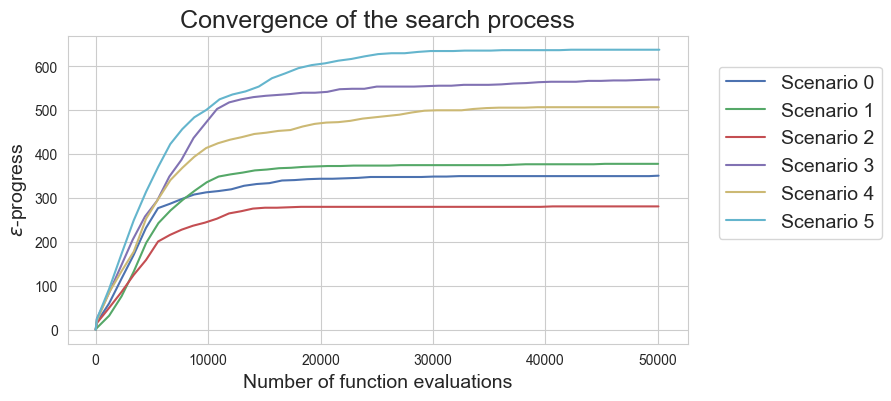

In [14]:
# Set colors for the plot
colors = sns.color_palette("deep6")

# Initiate plot
fig, ax = plt.subplots(ncols=1, sharex=True, figsize=(8,4))
ax.set_xlabel('Number of function evaluations', fontsize=14)
ax.set_ylabel('$\epsilon$-progress', fontsize=14)
ax.set_title("Convergence of the search process", fontsize=18)

# Add the convergence for each scenario
for scen_n, scenario in enumerate(scenarios_to_evaluate):
    
    # Load convergence file
    convergence_file_name = "results/S3_scenario_{}_convergence.csv".format(scen_n)
    convergence = pd.read_csv(convergence_file_name, index_col=0)
        
    # Add this scenario to the plot
    ax.plot(convergence.nfe, convergence.epsilon_progress,
            color=colors[scen_n], label='Scenario {}'.format(scen_n))
    

# Finalize plot
plt.legend(loc=2, bbox_to_anchor=(1.05, 0.9), borderaxespad=0., fontsize=14)
plt.savefig("figures/S3_scenarios_convergence.png", dpi=300, bbox_inches='tight')
plt.show()

#### 3.3 Restrict candidate solutions
The solution space is restricted based on the Delta Commission's crucial objective of <0.01 deaths, as well as a desire to minimize costs and damage.

In [15]:
# Function to select the solutions that meet certain thresholds
def restrict_candidate_solutions(results):
    
    # Set the threshold values
    thresholds_deaths = (results['Expected Number of Deaths'] < 0.005)
    thresholds_costs = (results['Total Investment Costs'] < np.percentile(results['Total Investment Costs'], 75))
    thresholds_damage = (results['Expected Annual Damage'] < np.percentile(results['Expected Annual Damage'], 75))
    
    # Select those results (solutions) that meet the threshold values
    relevant_solutions = results[thresholds_deaths & (thresholds_costs | thresholds_damage)]
    
    return relevant_solutions

In [16]:
optimization_outcomes = ['Expected Number of Deaths', 'Total Investment Costs', 'Expected Annual Damage']

In [17]:
# Select the relevant candidate solutions, based on threshold values
results_0_relevant = restrict_candidate_solutions(results_0)
results_1_relevant = restrict_candidate_solutions(results_1)
results_2_relevant = restrict_candidate_solutions(results_2)
results_3_relevant = restrict_candidate_solutions(results_3)
results_4_relevant = restrict_candidate_solutions(results_4)
results_5_relevant = restrict_candidate_solutions(results_5)

# Create dataframes with the relevant outcomes
outcomes_0_relevant = results_0_relevant.loc[:, [o for o in optimization_outcomes]]
outcomes_1_relevant = results_1_relevant.loc[:, [o for o in optimization_outcomes]]
outcomes_2_relevant = results_2_relevant.loc[:, [o for o in optimization_outcomes]]
outcomes_3_relevant = results_3_relevant.loc[:, [o for o in optimization_outcomes]]
outcomes_4_relevant = results_4_relevant.loc[:, [o for o in optimization_outcomes]]
outcomes_5_relevant = results_5_relevant.loc[:, [o for o in optimization_outcomes]]

# Create dataframes with the relevant policies
policies_0_relevant = results_0_relevant.loc[:, [l.name for l in dike_model.levers]]
policies_1_relevant = results_1_relevant.loc[:, [l.name for l in dike_model.levers]]
policies_2_relevant = results_2_relevant.loc[:, [l.name for l in dike_model.levers]]
policies_3_relevant = results_3_relevant.loc[:, [l.name for l in dike_model.levers]]
policies_4_relevant = results_4_relevant.loc[:, [l.name for l in dike_model.levers]]
policies_5_relevant = results_5_relevant.loc[:, [l.name for l in dike_model.levers]]

# Also create dataframes with all outcomes, for later comparison
outcomes_0 = results_0.loc[:, [o for o in optimization_outcomes]]
outcomes_1 = results_1.loc[:, [o for o in optimization_outcomes]]
outcomes_2 = results_2.loc[:, [o for o in optimization_outcomes]]
outcomes_3 = results_3.loc[:, [o for o in optimization_outcomes]]
outcomes_4 = results_4.loc[:, [o for o in optimization_outcomes]]
outcomes_5 = results_5.loc[:, [o for o in optimization_outcomes]]

In [18]:
# Show the impact on the number of reults
print("All: ", len(results_0), "   Relevant: ", len(results_0_relevant))
print("All: ", len(results_1), "   Relevant: ", len(results_1_relevant))
print("All: ", len(results_2), "   Relevant: ", len(results_2_relevant))
print("All: ", len(results_3), "   Relevant: ", len(results_3_relevant))
print("All: ", len(results_4), "   Relevant: ", len(results_4_relevant))
print("All: ", len(results_5), "   Relevant: ", len(results_5_relevant))

All:  43    Relevant:  11
All:  46    Relevant:  9
All:  33    Relevant:  10
All:  59    Relevant:  12
All:  49    Relevant:  10
All:  86    Relevant:  12


#### 3.4 Show trade-offs for candidate solutions: per scenario

In [19]:
# Parallel coordinate plot for a single scenario
def plot_candidates_per_scenario(all_outcomes, relevant_outcomes, scen_n):
    # set limits
    limits = parcoords.get_limits(all_outcomes)

    # create plot
    paraxes = parcoords.ParallelAxes(limits, formatter={o.name:".0e" for o in dike_model.outcomes})
    paraxes.plot(all_outcomes, color='grey', alpha=0.5,
                 label="All policies (n={})".format(len(all_outcomes)))
    paraxes.plot(relevant_outcomes, color='darkgreen', alpha=0.5, linewidth=2, 
                 label="Policies of interest (n={})".format(len(relevant_outcomes)))
    paraxes.legend()
    
    # show plot
    fig = paraxes.fig
    fig.set_size_inches(15, 15)
    fig.suptitle("Scenario {}: outcomes under different policies".format(scen_n), fontsize=18)
    plt.savefig("figures/S3_parcoords_scenario_{}.png".format(scen_n), dpi=300, bbox_inches='tight')
    plt.show()

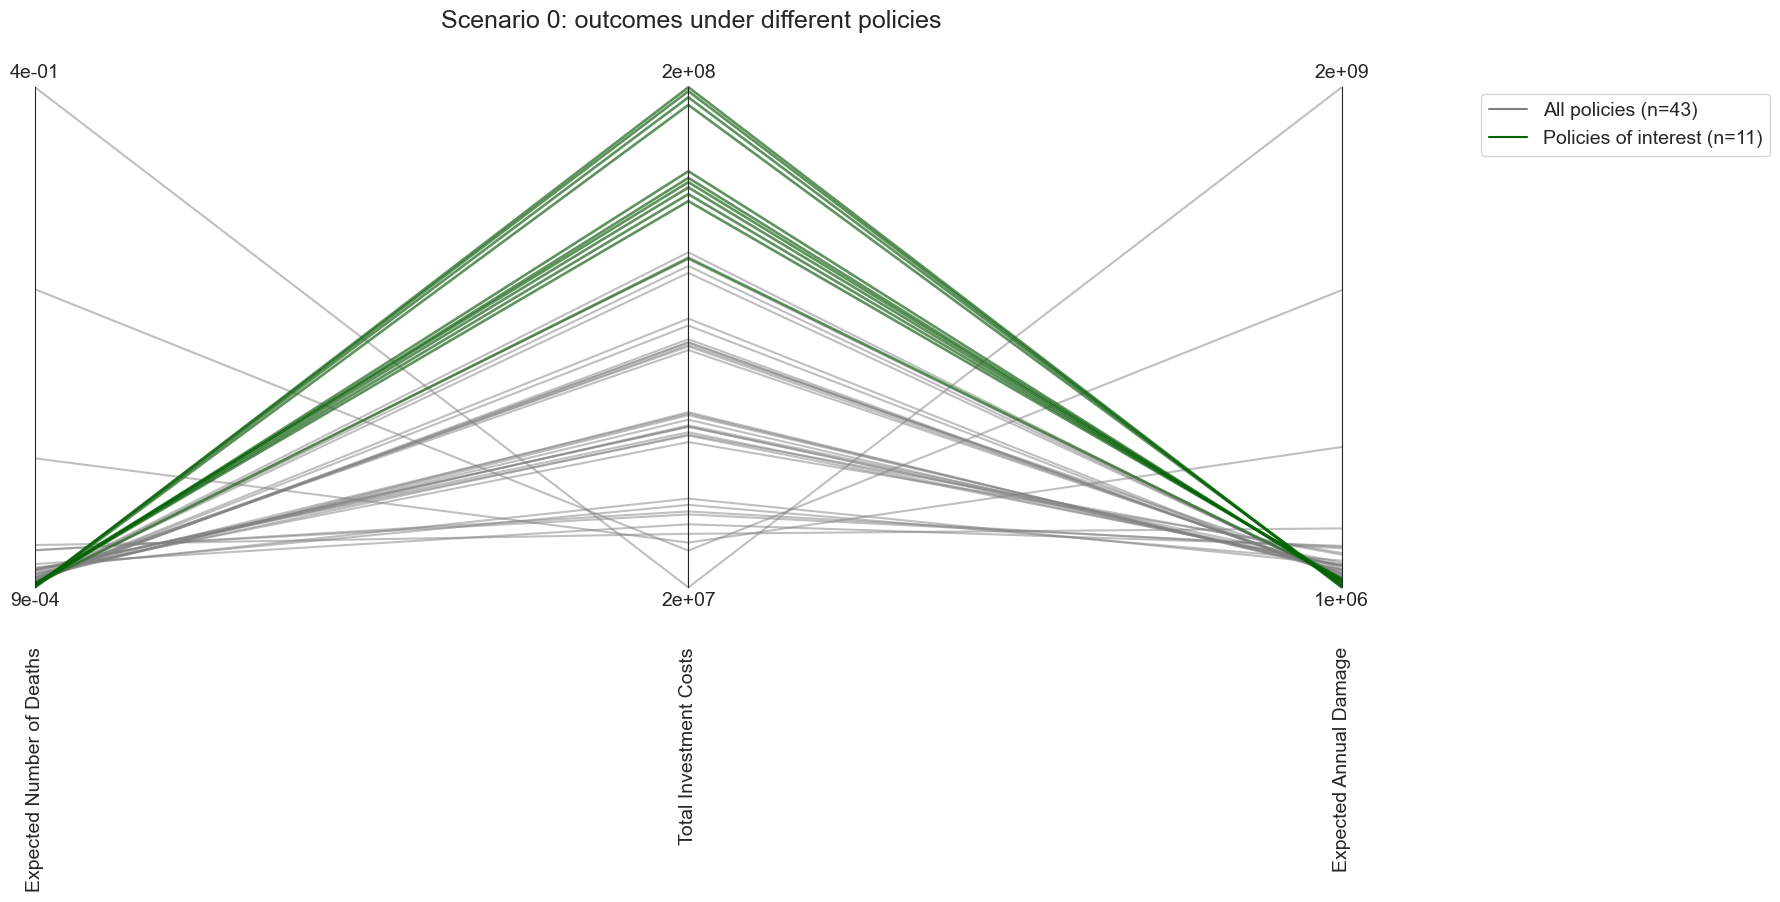

In [20]:
# Plot the relevant solutions on top of all solutions for scenario 0
plot_candidates_per_scenario(outcomes_0, outcomes_0_relevant, 0)

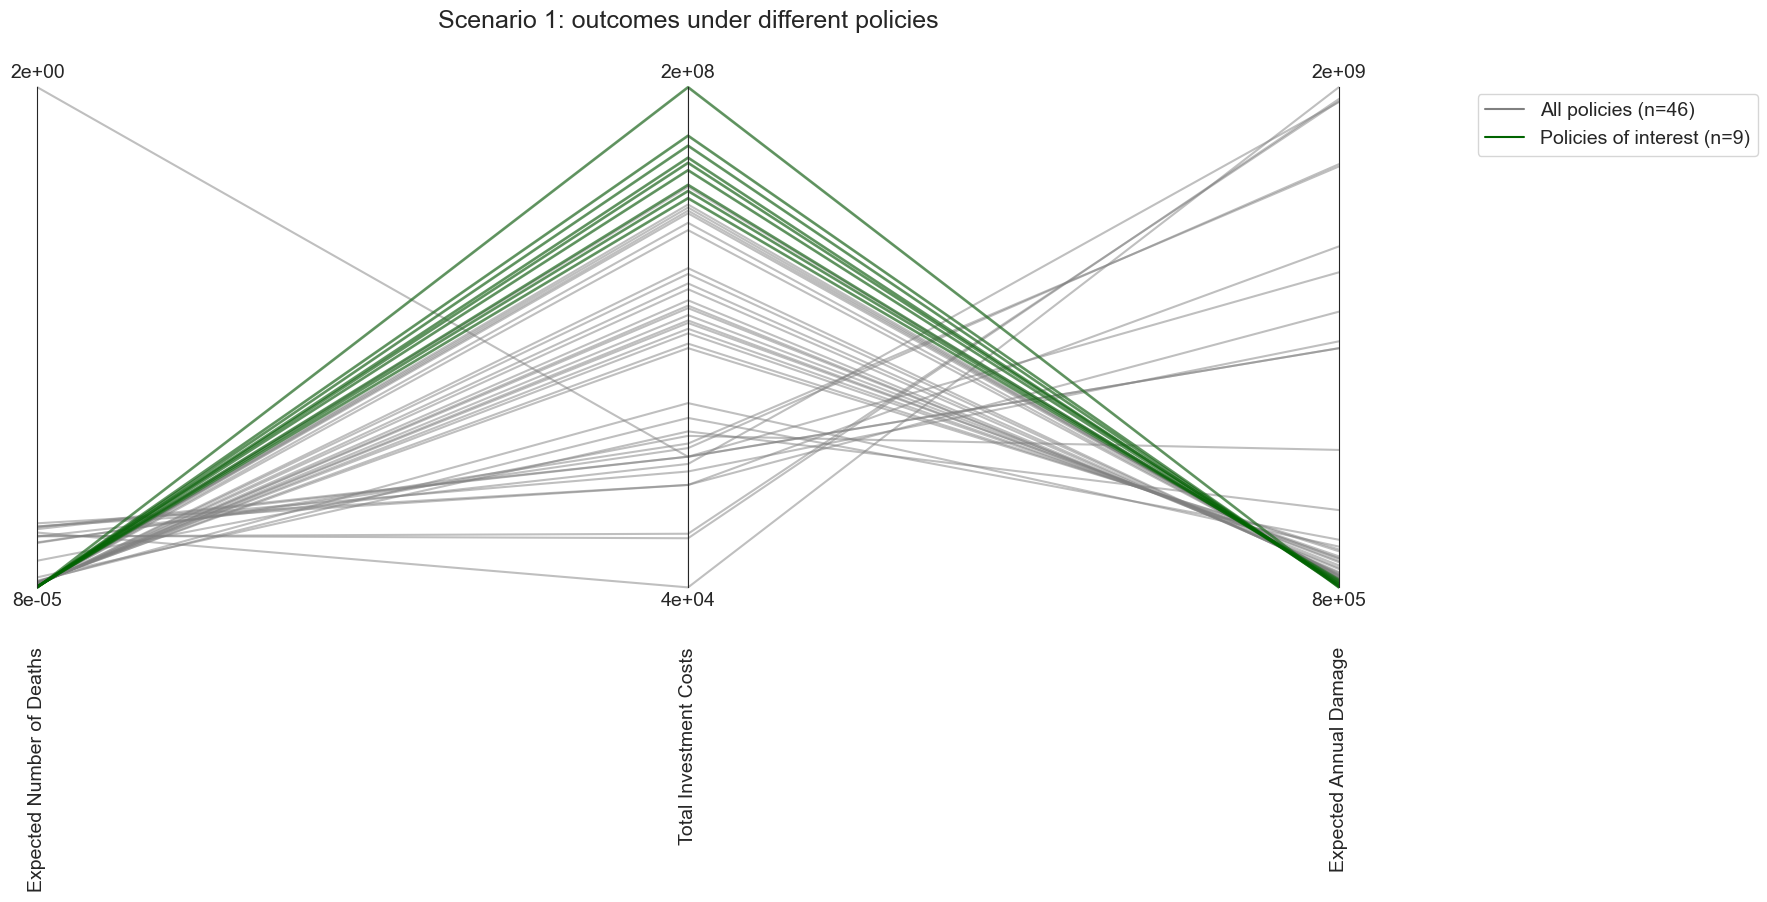

In [21]:
# Plot the relevant solutions on top of all solutions for scenario 1
plot_candidates_per_scenario(outcomes_1, outcomes_1_relevant, 1)

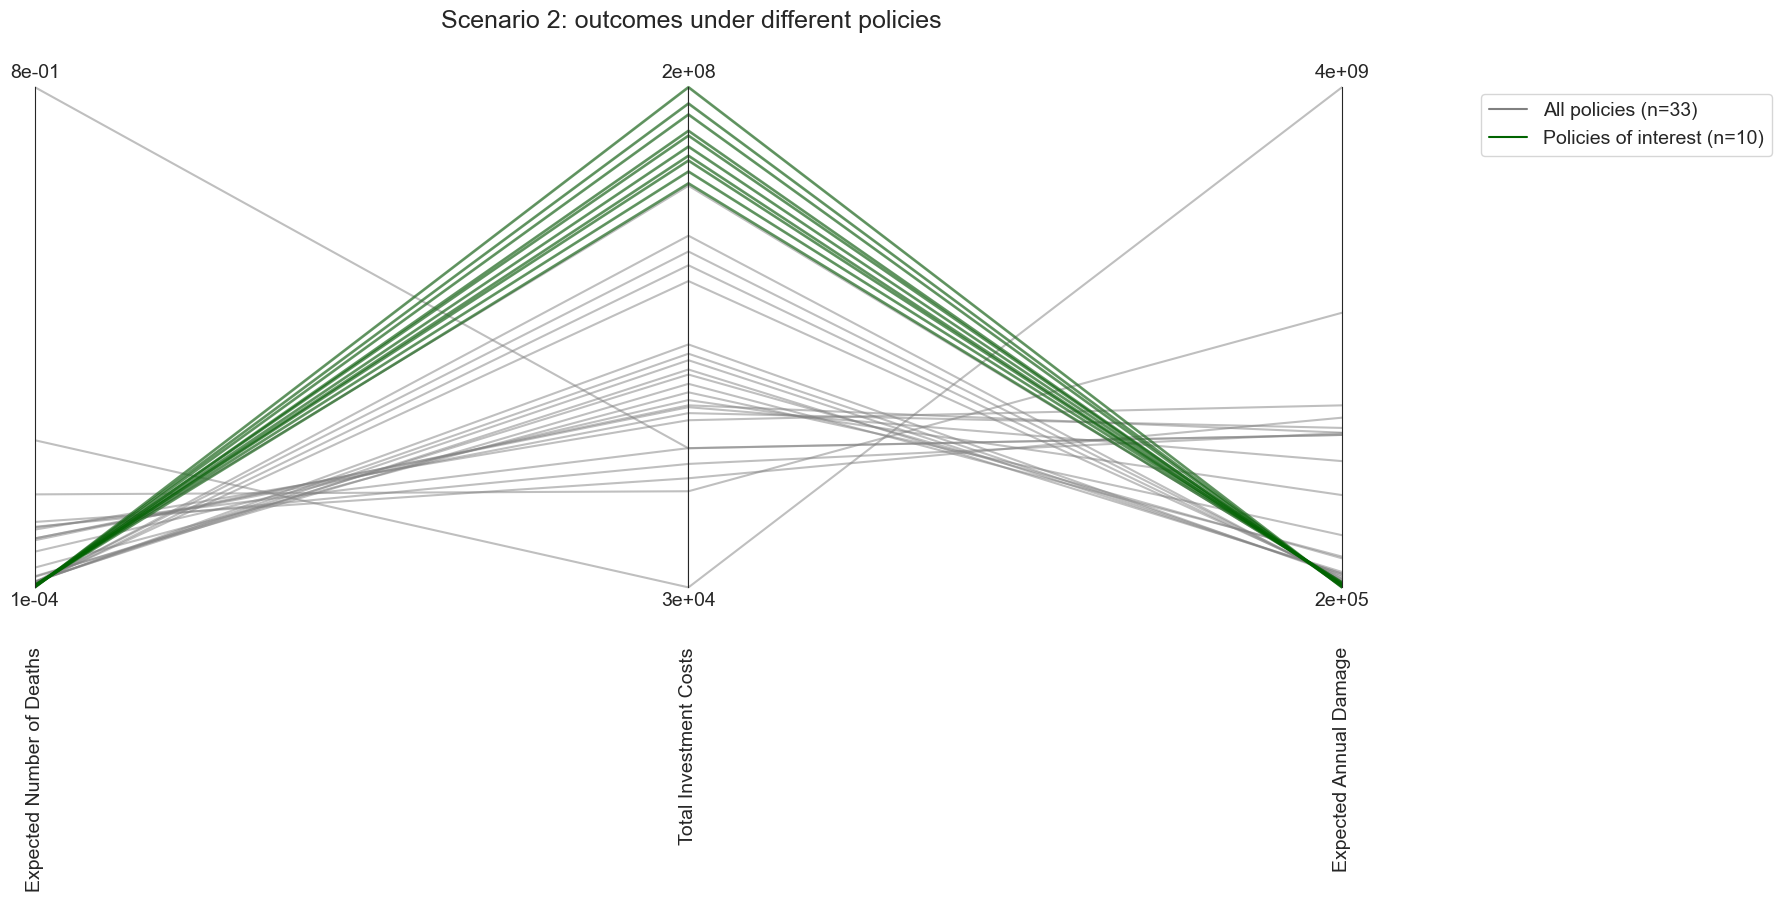

In [22]:
# Plot the relevant solutions on top of all solutions for scenario 2
plot_candidates_per_scenario(outcomes_2, outcomes_2_relevant, 2)

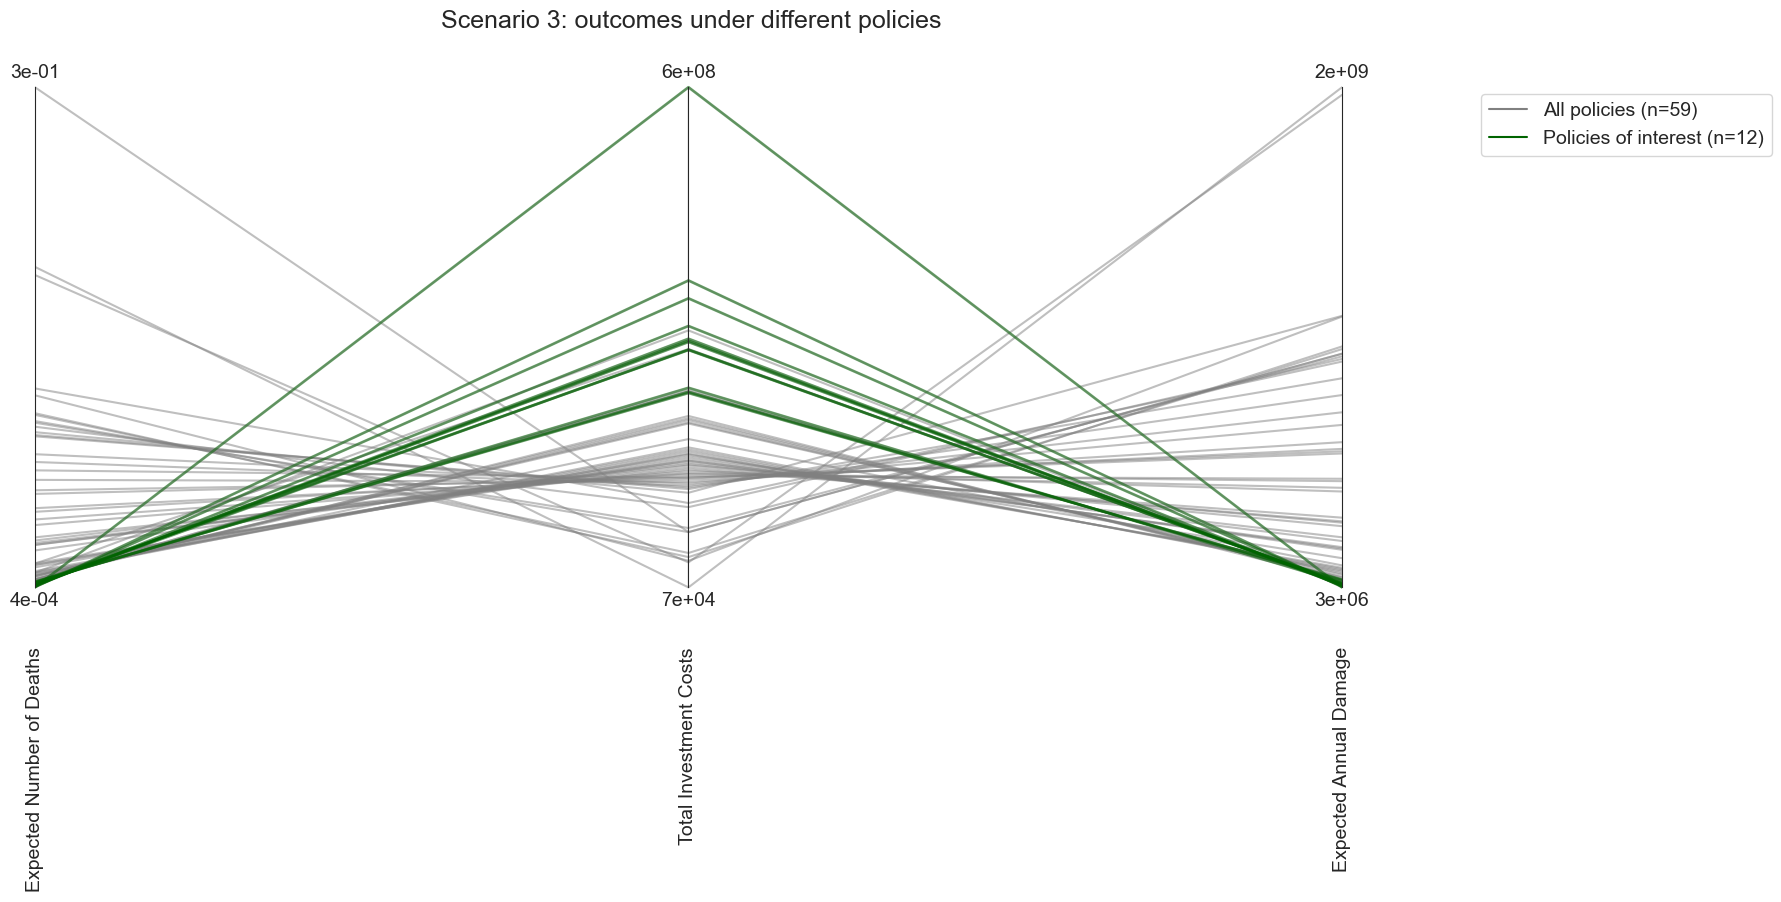

In [23]:
# Plot the relevant solutions on top of all solutions for scenario 3
plot_candidates_per_scenario(outcomes_3, outcomes_3_relevant, 3)

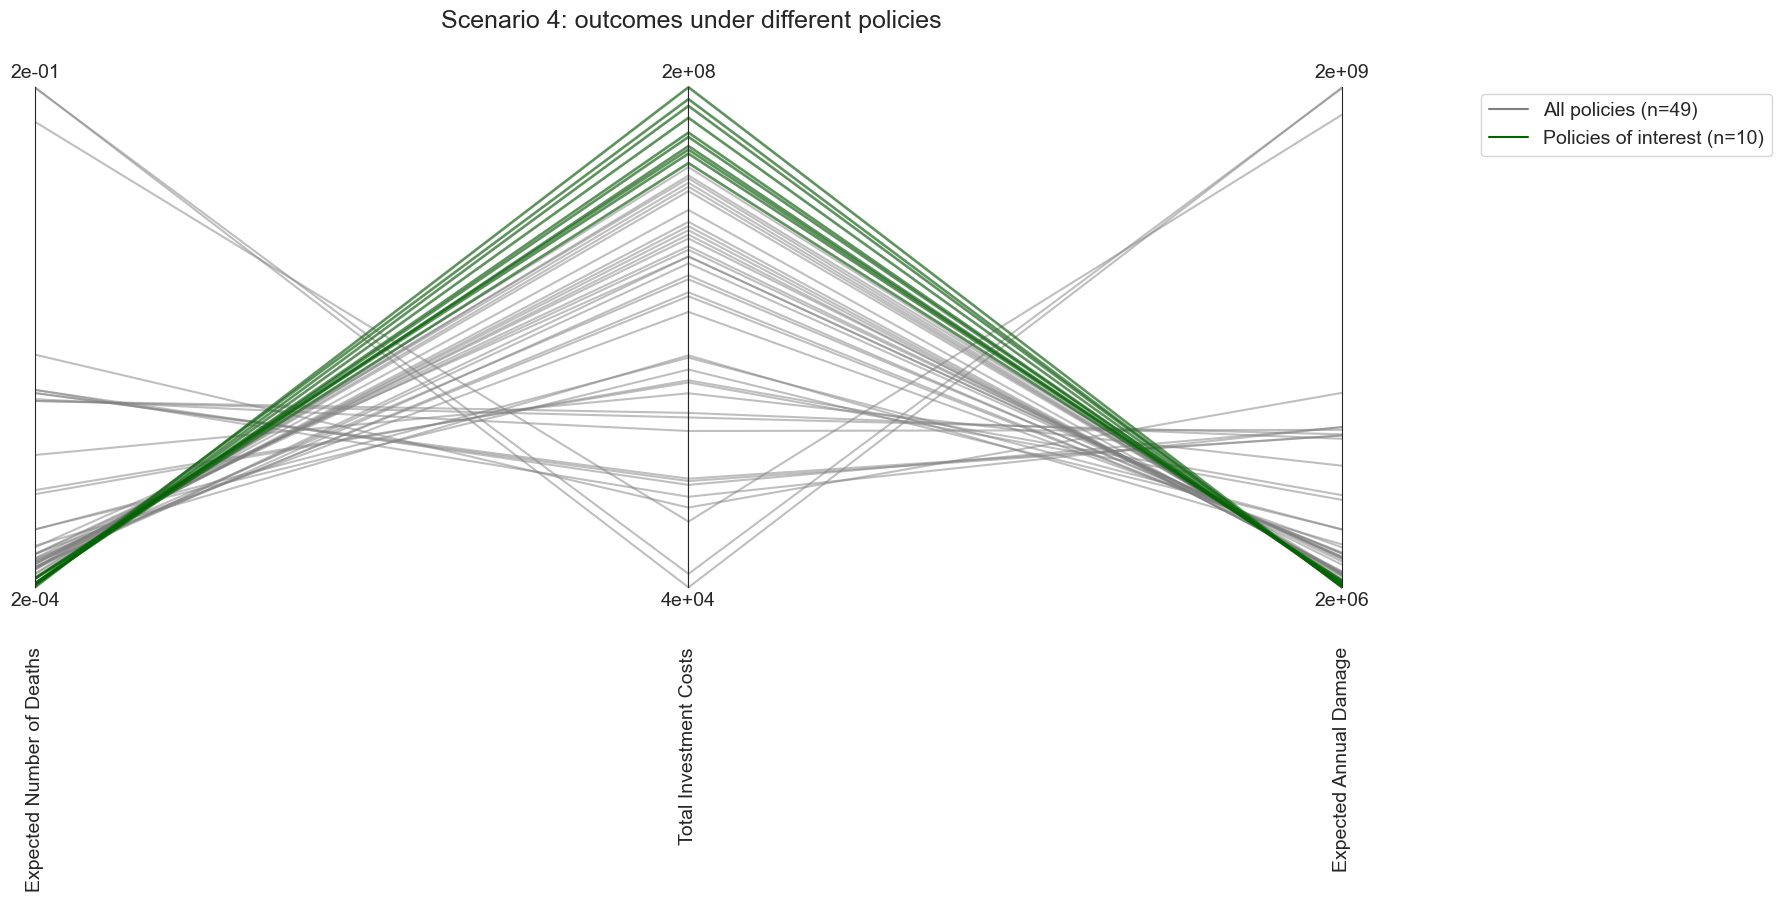

In [24]:
# Plot the relevant solutions on top of all solutions for scenario 4
plot_candidates_per_scenario(outcomes_4, outcomes_4_relevant, 4)

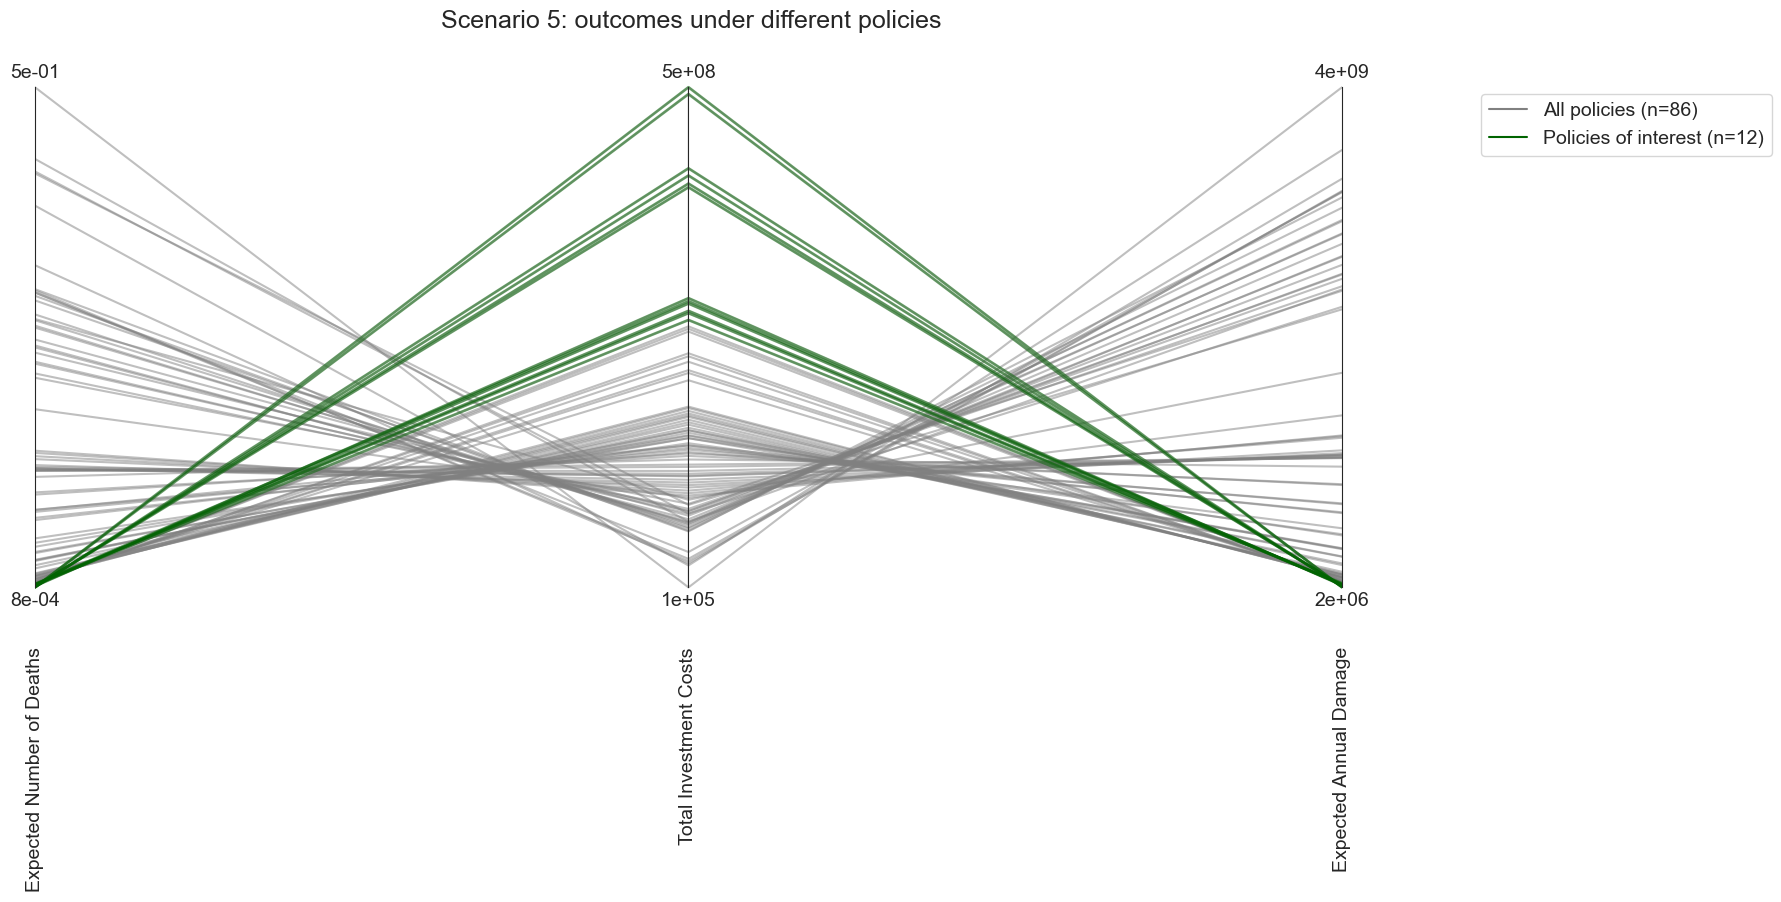

In [25]:
# Plot the relevant solutions on top of all solutions for scenario 5
plot_candidates_per_scenario(outcomes_5, outcomes_5_relevant, 5)

#### 3.5 Show trade-offs for candidate solutions: all scenarios

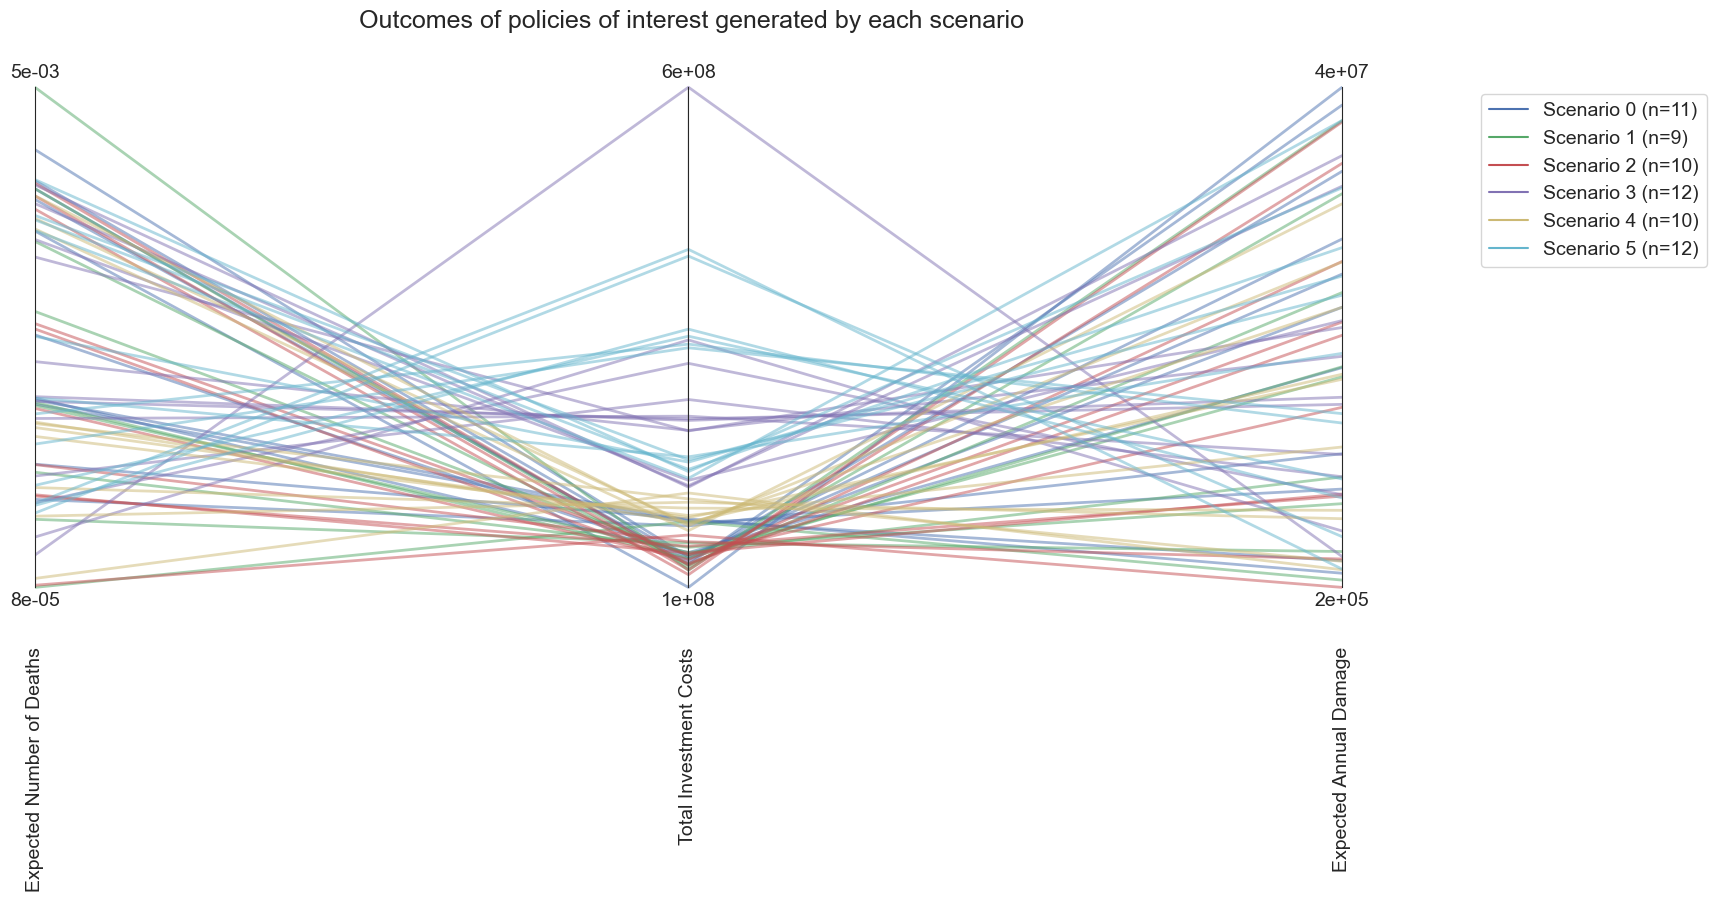

In [26]:
# Relevant solutions for all scenarios in one plot
outcomes_all_relevant = pd.concat([outcomes_0_relevant, outcomes_1_relevant,
                                   outcomes_2_relevant, outcomes_3_relevant,
                                   outcomes_4_relevant, outcomes_5_relevant])
limits = parcoords.get_limits(outcomes_all_relevant)

# Create plot
colors = sns.color_palette("deep6")
paraxes = parcoords.ParallelAxes(limits, formatter={o.name:".0e" for o in dike_model.outcomes})
paraxes.plot(outcomes_0_relevant, color=colors[0], alpha=0.5, linewidth=2, 
             label="Scenario 0 (n={})".format(len(outcomes_0_relevant)))
paraxes.plot(outcomes_1_relevant, color=colors[1], alpha=0.5, linewidth=2, 
             label="Scenario 1 (n={})".format(len(outcomes_1_relevant)))
paraxes.plot(outcomes_2_relevant, color=colors[2], alpha=0.5, linewidth=2, 
             label="Scenario 2 (n={})".format(len(outcomes_2_relevant)))
paraxes.plot(outcomes_3_relevant, color=colors[3], alpha=0.5, linewidth=2, 
             label="Scenario 3 (n={})".format(len(outcomes_3_relevant)))
paraxes.plot(outcomes_4_relevant, color=colors[4], alpha=0.5, linewidth=2, 
             label="Scenario 4 (n={})".format(len(outcomes_4_relevant)))
paraxes.plot(outcomes_5_relevant, color=colors[5], alpha=0.5, linewidth=2, 
             label="Scenario 5 (n={})".format(len(outcomes_5_relevant)))
paraxes.legend()

# Show plot
fig = paraxes.fig
fig.set_size_inches(15, 15)
fig.suptitle("Outcomes of policies of interest generated by each scenario", fontsize=18)
plt.savefig("figures/S3_parcoords_relevant_policies_all_scenarios.png", dpi=300, bbox_inches='tight')
plt.show()

#### 3.6 Retrieve candidate solutions (policies) to analyse

In [27]:
# Create a dataframe with all policies
policies = pd.concat([policies_0_relevant, policies_1_relevant,
                      policies_2_relevant, policies_3_relevant,
                      policies_4_relevant, policies_5_relevant])
# Drop duplicates and reset the index
policies = policies.reset_index(drop=True).drop_duplicates().reset_index(drop=True)

In [28]:
policies.shape

(64, 31)

In [29]:
policies.head()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,1,1,1,0,...,0,9,0,0,5,0,0,2,0,0
1,0,0,0,0,0,0,1,1,1,0,...,0,10,0,0,3,0,0,0,0,0
2,0,0,0,0,0,0,1,1,1,0,...,0,10,0,0,3,0,0,1,0,0
3,0,0,0,0,0,0,1,1,1,0,...,0,10,0,0,5,0,0,2,0,0
4,0,0,0,0,0,0,1,1,1,0,...,0,10,0,0,5,0,0,2,0,0


#### 3.7 Save the selected policies to a csv file

In [30]:
polcies_file_name = 'results/S3_candidate_policies.csv'   # _s0-3
policies.to_csv(polcies_file_name)

#### 3.8 Evaluate candidate solution characteristics

In [31]:
polcies_file_name = 'results/S3_candidate_policies.csv'   #_s0-3
policies = pd.read_csv(polcies_file_name, index_col=0)

In [32]:
policies.columns

Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'],
      dtype='object')

In [33]:
# Define the different types of levers present in the policies
RfR_levers = ['0_RfR 0', '0_RfR 1', '0_RfR 2',
              '1_RfR 0', '1_RfR 1', '1_RfR 2',
              '2_RfR 0', '2_RfR 1', '2_RfR 2',
              '3_RfR 0', '3_RfR 1', '3_RfR 2',
              '4_RfR 0', '4_RfR 1', '4_RfR 2']
EWS_lever = ['EWS_DaysToThreat']
DikeIncrease_levers = ['A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
                       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
                       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
                       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
                       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2']

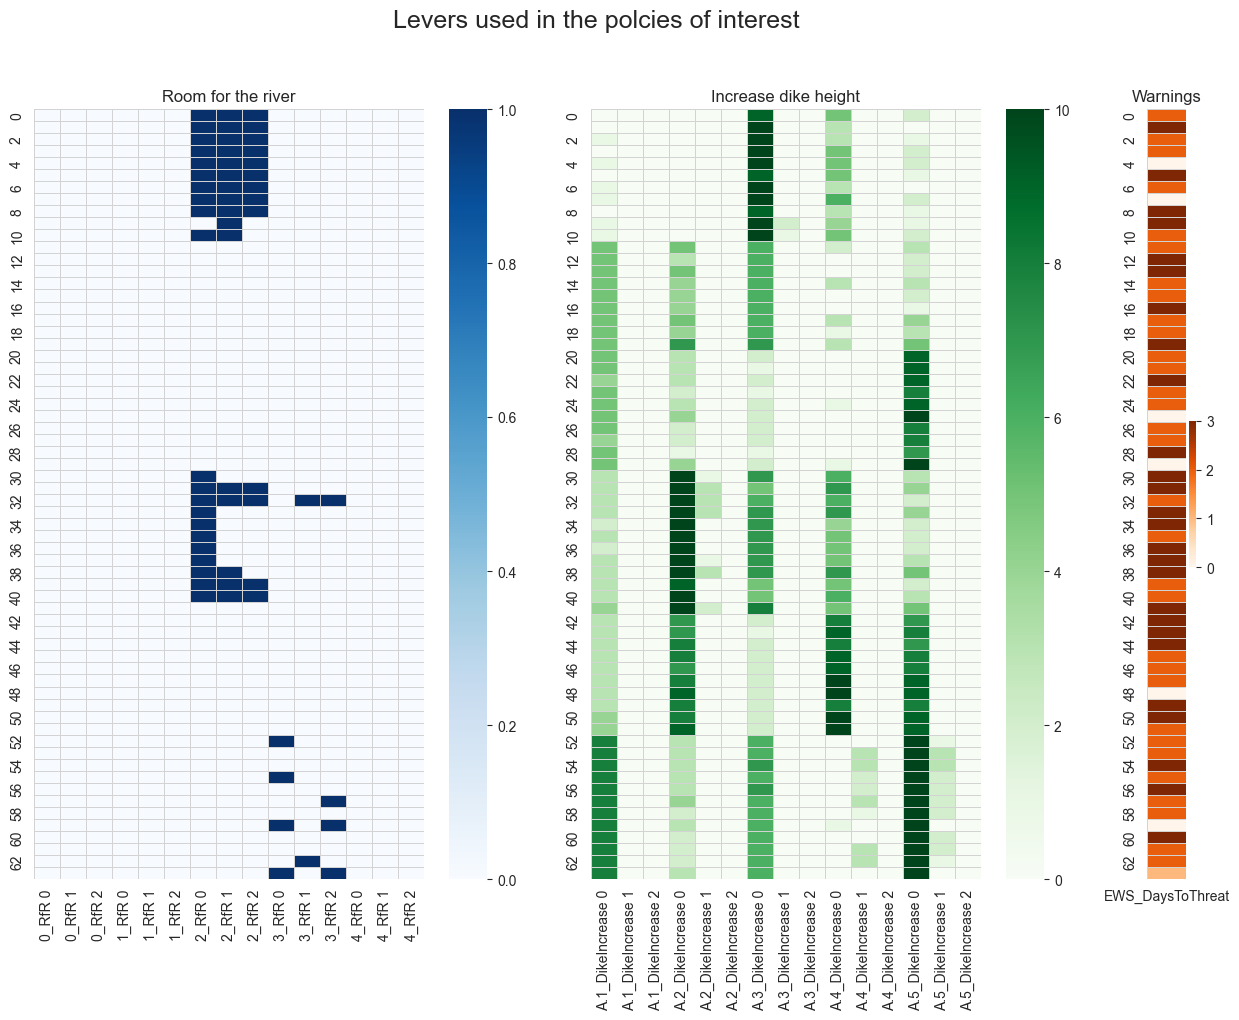

In [34]:
# Plot the levers present in the selected policies
fig, ax = plt.subplots(1,3, figsize=(15,10), width_ratios=[10, 10, 1]) #, sharex=True) 

# Plot the room for the river levers
sns.heatmap(policies.loc[:, RfR_levers], cmap='Blues', ax=ax[0], linewidths=0.5, linecolor='lightgrey')
ax[0].set_title('Room for the river')

# Plot the dike increase levers
sns.heatmap(policies.loc[:, DikeIncrease_levers], cmap='Greens', ax=ax[1], linewidths=0.5, linecolor='lightgrey')
ax[1].set_title('Increase dike height')

# Plot the room for the river levers
sns.heatmap(policies.loc[:, EWS_lever], cmap='Oranges', ax=ax[2], linewidths=0.5, linecolor='lightgrey')
ax[2].set_title('Warnings')

# Save and show figure
fig.suptitle("Levers used in the polcies of interest", fontsize=18)
plt.savefig("figures/S3_heatmap_relevant_policies_levers.png", dpi=300, bbox_inches='tight')
plt.show()

Note: policies are grouped by the scenario in which they were generated (the dataframes were concatenated below each other). You can see that the policies are depenedent on the scenario, since there is a pattern!

## Step 4. Trade-Off Analysis (next script)
#### *See script: G11_S4_TradeOffAnalysis.ipynb*